# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import pandas as pd

from matplotlib import pyplot as plt

# 2. Keypoints using MP Hands

importiamo il modello Holistic di MediaPipe

In [3]:
mp_hands = mp.solutions.hands # Hands model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

# 3. Extract Keypoint Function

restituisce il numero dei landmark usati per la parte del corpo specificata

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

Facciamo la stessa cosa, ma tutto su una sola linea.

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

qui facciamo quello fatto sopra, ma in maniera pù organizzata, in una funzione apposita:

In [5]:
def extract_keypoints_hands(results, hand_landmarks):
    h = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten() if results.multi_hand_landmarks else np.zeros(21*3)    
    return h

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

### abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

# 4. Setup and Preprocessing

In [141]:
labels = np.array(["ok", "peace", "rock", "victory", "mano del gaucho", "saluto"])

In [7]:
DATADIR = r"D:\TMS\dataset\hagrid\train"
TESTDIR = r"D:\TMS\dataset\hagrid\test"

creo cartella keypoints

In [11]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    try:
        os.makedirs(os.path.join(label_path, "keypoints"))
    except: pass

elimino frame per cui non sono stati trovati landmark

In [74]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    kp_name_list = []

    for kp in os.listdir(os.path.join(label_path, "keypoints")):
        kp_name = kp[0:5]
        kp_name_list.append(kp_name)

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)

        frame_name = frame[0:5]

        if not frame_name in kp_name_list:
            os.remove(frame_path)

### Resizing

In [12]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

rinomino i frame in modo che abbiano nomi di interi consecutivi

In [75]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    count = 0
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)
        count += 1

        # rinomino i frame in modo che abbiano nomi di interi consecutivi
        new_frame = (str(count)).zfill(5) + ".jpg"
        new_frame_path = os.path.join(label_path, new_frame)
        os.rename(frame_path, new_frame_path)  

In [76]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    count = 0
    print(label)

    kp_path = os.path.join(label_path,"keypoints")
   
    for kp in os.listdir(kp_path):
        kp_path_single = os.path.join(kp_path, kp)
        count += 1

        # rinomino i frame in modo che abbiano nomi di interi consecutivi
        new_name = (str(count)).zfill(5) + ".npy"
        new_kp_path = os.path.join(kp_path, new_name)
        #print(kp_path_single, new_kp_path)
        os.rename(kp_path_single, new_kp_path)  

mano del gaucho
saluto


resize

In [16]:
for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    print(label)
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)
        
        # resizing & overwriting
        img = cv2.imread(frame_path)  
        #print(frame_path)      
        (w, h) = img.shape[:2]   

        img_resized = image_resize(img, height = 240)         
        cv2.imwrite(frame_path, img_resized)        

mano del gaucho
saluto


### test

In [19]:
def get_and_append_img(CHAR, path, img):

    img_num = img[0:CHAR] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo   
    img_array = cv2.imread(path)  # convert to array               
    return img_array, img_num

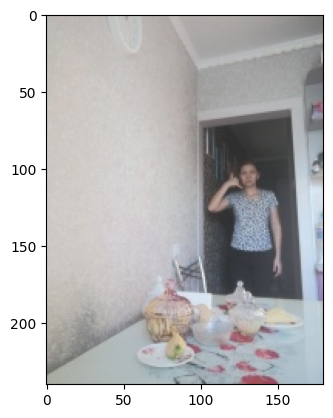

In [65]:
DATADIR2 = r"D:\TMS\dataset\hagrid\train\mano del gaucho"

path_test = os.path.join(DATADIR2, '00005.jpg') 
frame_test = cv2.imread(path_test)  # convert to array
plt.imshow(cv2.cvtColor(frame_test, cv2.COLOR_BGR2RGB)) 

[ 6.80648386e-01  5.35230339e-01  3.47429364e-07  6.38765574e-01
  5.30778289e-01 -1.93230081e-02  6.00921452e-01  5.21222293e-01
 -3.36335264e-02  5.68076253e-01  5.15630007e-01 -4.70752716e-02
  5.38403213e-01  5.15638828e-01 -6.16167150e-02  6.18927956e-01
  4.82840449e-01 -2.13712845e-02  5.93735218e-01  4.63523954e-01
 -3.52234058e-02  5.79507113e-01  4.50981021e-01 -4.80432436e-02
  5.68466544e-01  4.40279424e-01 -5.78893386e-02  6.52825713e-01
  4.77533698e-01 -2.45374460e-02  6.51008010e-01  4.54072058e-01
 -3.41005176e-02  6.50629878e-01  4.39320683e-01 -4.45381850e-02
  6.50875866e-01  4.27189201e-01 -5.30003384e-02  6.85831189e-01
  4.79636580e-01 -3.01808175e-02  6.92650735e-01  4.56842750e-01
 -4.21087220e-02  6.95435584e-01  4.43347752e-01 -5.40065393e-02
  6.98310077e-01  4.32044148e-01 -6.28449544e-02  7.15936959e-01
  4.86974865e-01 -3.74804623e-02  7.37851501e-01  4.71243829e-01
 -4.90695834e-02  7.53443122e-01  4.61414844e-01 -5.52221648e-02
  7.66721725e-01  4.52554

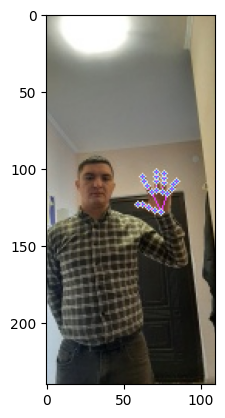

In [64]:
LAST_CHAR = 5

# OTTENGO IL FRAME 
with mp_hands.Hands(max_num_hands = 1, min_detection_confidence=0.5, min_tracking_confidence = 0.5) as hands:   
    
    #img_array, img_num = get_and_append_img(LAST_CHAR, path_test, frame_test)
    image_h, results = mediapipe_detection(frame_test, hands)     
    
    annotated_image = image_h.copy()                  

    first_hand_keypoints = np.zeros(21*3)
    second_hand_keypoints = np.zeros(21*3)

    #TODO aggiustare perchè if lo fa già extract_keypoints
    if results.multi_hand_landmarks:
        
        # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
        for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

            mp_drawing.draw_landmarks(     
                annotated_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                )

            if num == 0: # prima mano riconosciuta 
                first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n1st hand shape:", first_hand_keypoints.shape)

            if num == 1: # seconda mano riconosciuta
                second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n2nd hand shape:", second_hand_keypoints.shape)

        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

    else:
        print("nessun kp trovato")
        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

    print(keypoints)    
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))     

# 5. Collect Keypoints ...

In [67]:
LAST_CHAR = 5

for label in labels:
    label_path = os.path.join(DATADIR, str(label))
    list_frames = os.listdir(label_path)
    list_frames.remove("keypoints")

    print(label)

    for frame in list_frames:
        frame_path = os.path.join(label_path, frame)

        with mp_hands.Hands(max_num_hands = 1, min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as hands:  
            
            img_array, img_num = get_and_append_img(LAST_CHAR, frame_path, frame)
            image_h, results = mediapipe_detection(img_array, hands)  
            
            first_hand_keypoints = np.zeros(21*3)
            second_hand_keypoints = np.zeros(21*3)

            #TODO aggiustare perchè if lo fa già extract_keypoints
            if results.multi_hand_landmarks:
                
                # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
                for num, hand_landmarks in enumerate(results.multi_hand_landmarks):              

                    if num == 0: # prima mano riconosciuta 
                        first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                        #print("\n1st hand shape:", first_hand_keypoints.shape)

                    if num == 1: # seconda mano riconosciuta
                        second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                        #print("\n2nd hand shape:", second_hand_keypoints.shape)

                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])
                
                # salvo i keypoints rilevati ed estratti
                npy_path = os.path.join(label_path, "keypoints", img_num)
                np.save(npy_path, keypoints)                               

            #else:
                #print("results:",results.multi_hand_landmarks)
                #print("nessun kp trovato", frame_path, "\n")
                #keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])              

mano del gaucho
saluto


# 6. Preprocess Data and Create Labels and Features

In [68]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [88]:
old_label_map = {label:num for num, label in enumerate(labels)}
label_map = {"mano del gaucho": 4, "saluto": 5}

In [91]:
old_label_map

{'mano del gaucho': 0, 'saluto': 1}

inseriamo tutti i keypoints estratti da ciascuna immagine in un array

In [102]:
all_kp = []
labels_list = []

for label in labels:
    label_path = os.path.join(DATADIR, str(label)) 
    kp_path = os.path.join(label_path, "keypoints")
    print(label)

    window = [] 
    
    for kp_num in range(1, 23130): #prendo i primi 23130 di ogni label, per avere un numero uguale di array-kp
        kp = (str(kp_num)).zfill(5) + ".npy"
        res = np.load(os.path.join(kp_path, kp))
        window.append(res)      

        labels_list.append(label_map[label])

    all_kp.append(window)    

mano del gaucho
saluto


In [100]:
np.array(window).shape

(25884, 126)

In [103]:
np.array(all_kp).shape

(2, 23129, 126)

In [105]:
all_kp_copy = np.array(all_kp).copy()
all_kp_copy.shape

(2, 23129, 126)

In [111]:
new_X = all_kp_copy.reshape((2*23129), 126)
new_X.shape

(46258, 126)

In [97]:
np.array(labels_list).shape

(50945,)

In [95]:
old_label_list = labels_list
print(old_label_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [13]:
y = np.array(labels_list) 

In [121]:
labels_list = old_label_list+labels_list
y = np.array(labels_list)
y.shape

(138774,)

In [78]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"

In [29]:
np.save(os.path.join(BASEDIR, "mytempfiles","X_array"), X)
np.save(os.path.join(BASEDIR, "mytempfiles","y_array"), y)

In [107]:
old_X = np.load(os.path.join(BASEDIR, "mytempfiles", "X_array.npy"))

In [109]:
old_X.shape

(92516, 126)

In [108]:
all_kp_pre = old_X.reshape((4, 23129, 126))
print(all_kp_pre.shape)

(4, 23129, 126)


In [114]:
# concateno i due array e le due liste
X = np.concatenate((old_X, new_X))
X.shape

(138774, 126)

dobbiamo ora splittare l'array dei keypoints, X, e la lista delle label associate a ciascun frame, y, negli insiemi di train e test

splittiamo mantenendo la proporzione:
- 80% train
- 20% test

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

In [123]:
y = to_categorical(labels_list).astype(int)

In [124]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(27755, 126)
(111019, 126)
(27755,)
(111019,)


avremo così:
- 111019 immagini di train
- 27755 immagini di test

# 7. Build and Train ML model / Neural Network

In [125]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneGroupOut

from sklearn.utils import shuffle

utilizzo un **Random Forest** come classificatore

In [126]:
pipeline = imbpipeline(steps = [['classifier', RandomForestClassifier(max_depth=None, random_state=None)]]) 

In [127]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

In [128]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [4, 6, 10, 12],
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [129]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'classifier__max_depth': 12, 'classifier__n_estimators': 200}
Cross-validation score: 0.9440095941588557


Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [130]:
y_test_predict = grid_search.predict(X_test)

In [131]:
y_test_predict_prob=grid_search.predict_proba(X_test)

In [132]:
# Metriche di valutazione
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

accuracy: 0.9445505314357774
precision: 0.9471473936902591
recall: 0.94455179693312
f1: 0.9449332516006836


[]

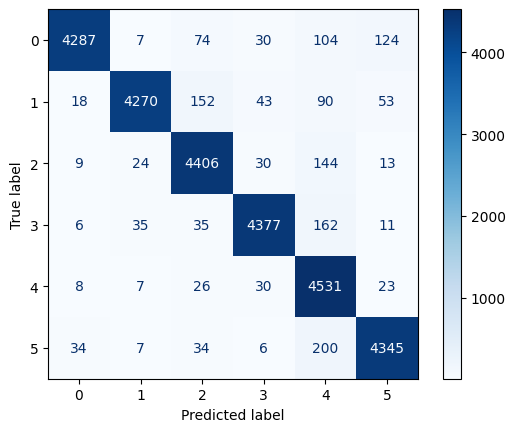

In [133]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

In [134]:
import pickle

In [135]:
filename = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\models_action\my_model_rndf.pickle"

In [136]:
# save model
model_rndf = grid_search.best_estimator_
pickle.dump(model_rndf, open(filename, "wb"))

In [27]:
# load model
grid_search = pickle.load(open(filename, 'rb'))

# DETECT from a single image

In [138]:
IMGDIR = r"C:\Users\follo\OneDrive\Desktop\rock.jpg"

image = cv2.imread(IMGDIR)
image_resized = image_resize(image, height = 240)  
#plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)) 

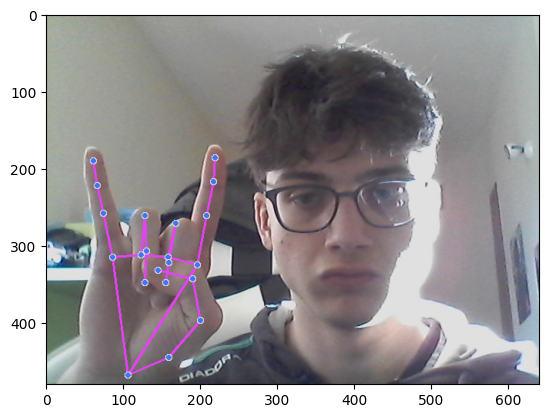

In [139]:
LAST_CHAR = 5

# OTTENGO IL FRAME 
with mp_hands.Hands(max_num_hands = 1, min_detection_confidence=0.5, min_tracking_confidence = 0.5) as hands:   
    
    image_h, results = mediapipe_detection(image, hands)     
    
    annotated_image = image_h.copy()                  

    first_hand_keypoints = np.zeros(21*3)
    second_hand_keypoints = np.zeros(21*3)

    #TODO aggiustare perchè if lo fa già extract_keypoints
    if results.multi_hand_landmarks:
        
        # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
        for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

            mp_drawing.draw_landmarks(     
                annotated_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                )

            if num == 0: # prima mano riconosciuta 
                first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n1st hand shape:", first_hand_keypoints.shape)

            if num == 1: # seconda mano riconosciuta
                second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n2nd hand shape:", second_hand_keypoints.shape)

        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

    else:
        print("nessun kp trovato")
        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

    #print(keypoints)    
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))  

In [144]:
res = grid_search.predict_proba([keypoints])
print(res)
print("idx:", np.argmax(res))
print(labels[np.argmax(res)])
print(res[0][np.argmax(res)])

[[0.04426765 0.11755287 0.74512158 0.01556643 0.03380277 0.04368871]]
idx: 2
rock
0.7451215758563647


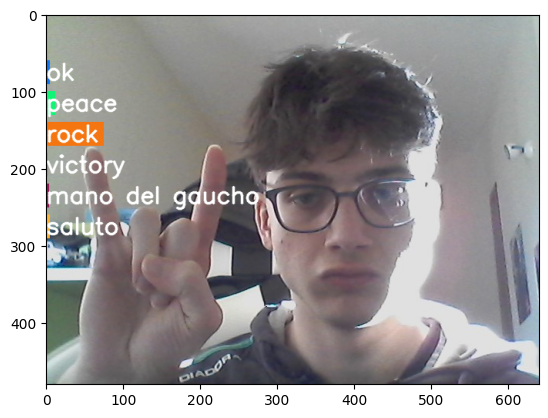

In [145]:
image_prob = prob_viz(res[0], labels, image, colors)
plt.imshow(cv2.cvtColor(image_prob, cv2.COLOR_BGR2RGB))  

# 8. Make Predictions

In [37]:
res = model.predict(X_test) #prendo tutte le predizioni dall'insieme di test
# res[0]: significa che prendo la prima prediction (quindi la prediction della prima azione presente in X_test)

13/13 [==============================] - 2s 42ms/step


poichè ad ogni azione è associata una probabilità, la mia predizione sarà quella che avrà probabilità **maggiore** fra esse

In [41]:
jester_gestures[np.argmax(res[2])] #qual'è l'azione con il più altro valore di probabilità associato?

'Stop Sign'

prendo la label della 4a azione: vedo quindi il *ground truth*

In [42]:
jester_gestures[np.argmax(y_test[2])]

'Stop Sign'

ovviamente, se le due azioni **coincidono** significa che il modello ha una **buona accuracy**

# 9. Save Weights

In [265]:
model.save('action2.h5')

In [ ]:
del model

In [36]:
model.load_weights(os.path.join(BASEDIR, "models_action", "action2.h5"))

# 10. Evaluation using Confusion Matrix and Accuracy

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [39]:
yhat = model.predict(X_test)

13/13 [==============================] - 1s 37ms/step


In [40]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [62]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[269,   0],
        [  8, 131]],

       [[275,   0],
        [ 10, 123]],

       [[254,  18],
        [  0, 136]]], dtype=int64)

In [41]:
accuracy_score(ytrue, yhat)

0.9558823529411765

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

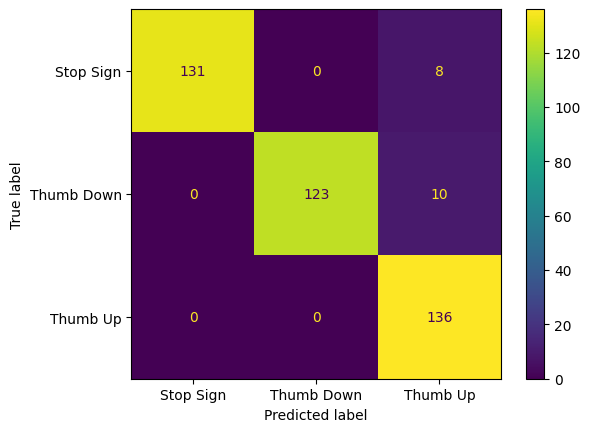

In [43]:
ConfusionMatrixDisplay.from_predictions(jester_gestures[ytrue], jester_gestures[yhat])

# 11. Test in Real Time

In [143]:
colors = [(245,117,16), (117,245,16), (16,117,245), (56,125,200), (88,22,152), (50,180,255)]
def prob_viz(res, jester_gestures, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, jester_gestures[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [146]:
y_test_predict.shape

(27755,)

In [148]:
# 1. New detection variables
sequence = []
predictions = []
gesto = ""
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue
        
        # Make detections
        image, results = mediapipe_detection(frame, hands)
        print(results)        
        print("which hand?", results.multi_handedness)

        first_hand_keypoints = np.zeros(21*3)
        second_hand_keypoints = np.zeros(21*3)
    
        if results.multi_hand_landmarks:
            for num, hand_landmarks in enumerate(results.multi_hand_landmarks):        

                mp_drawing.draw_landmarks(     
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(200,66,230), thickness=2, circle_radius=2)
                    )
                
                if num == 0:   
                    first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n1st hand kp:", first_hand_keypoints_test)
                if num == 1:
                    second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n2nd hand kp:", second_hand_keypoints_test)

            keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])    

        else: 
            keypoints = np.zeros(21*6)
            print("no detect")
                        
        # 2. Prediction logic
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = grid_search.predict_proba([keypoints])
            res = res[0] # è contenuto in un array | TODO togliere
            print(labels[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    gesto = labels[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, labels, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no